Title: What Makes The Flappy Bird Flap?   
Date: 2023-03-17   
Category: Tech   
Tags: Simulations   
Slug: modeling-flappy-bird   
Summary: If we can model a [bouncing ball]({filename}/bouncing-balls.md), what about a flapping bird?   
Status: draft   

[Previously]({filename}/bouncing-balls.md), I wrote a lot about [Hybrid Dynamic Systems]({https://dl.acm.org/doi/pdf/10.1145/3337722.3337757}) and simulating a simple bouncing ball.

I wrote a bunch of something adjacent to Python code about it. What about a real video game? Can we use this framework to simulate a video game?

### The Model of Flappy Bird
Ok, to recap, I need four functions:  

* ```flow(...)``` tells me how the game changes over time, by taking in the current time and the state, and giving me the derivative of the state with respect to time  

* ```jump(...)``` tells me how the game changes instantly, snapping from one state to another. It takes in a time and a state and returns a different state.  

* ```flow_check(...)``` tells me if the game should be flowing or not. It takes in a time and a state and returns an integer (0 for not flowing, 1 for flowing). It's gotta be an `int` to work with other libraries to use this model.  

* ```jump_check(...)``` tells me if the game should jump or not. It takes in a time and a state and returns an integer (0 for do not jump, 1 for jump). It's gotta be an `int` for the same reasons ```flow_check``` does.

All these functions deal with state... so what state does flappy bird need? Well, we'll need both vertical and horizontal position because those will change. We'll need vertical velocity because the rate that the bird rises (or falls) changes based on time and input.

Oh! And something to track if the player is pushing the flap button or not. And, I know that eventually this all needs to be an `array-like`.

In [1]:
from collections import namedtuple

# as before, a named tuple doesn't really solve our problems
# but it does make the constructor a little nicer
# its easy enough to make a class that implements the right protocols, but compactness, yeah?
State = namedtuple('State', ['x_pos', 'y_pos', 'y_vel', 'pressed'])
state = State(x_pos=0.0, y_pos=2.0, y_vel=0.0, pressed=1)
print(state)

State(x_pos=0.0, y_pos=2.0, y_vel=0.0, pressed=1)


Ok, so let's march through, starting with `flow`. Flappy the bird always moves right at a constant speed, so the derivative of their `x` position is a constant velocity. When they're falling, Flappy the bird accelerates-- so when `pressed == 0`, `y` position should change according to whatever `y` velocity is, and `y` velocity should change at a magic `-9.81`. `pressed` should never change during flows, it's derivative is `0`. So flow looks a little like...

In [2]:
from typing import Tuple
# delta here is just shorthand for "change in", what this is tracking is how the corresponding state elements
# change over time 
StateDerivative = namedtuple('StateDerivative', ['delta_x_pos', 'delta_y_pos', 'delta_y_vel', 'delta_pressed'])
def flow(time:float, state:State) -> Tuple[float, float, float, int]:
    return StateDerivative(
        delta_x_pos=2.0, # this is a bit of an extra magic number. It could be anything positive.
        delta_y_pos=state[2], # this is y_vel in our state vector
        delta_y_vel=-9.81,
        delta_pressed=0
    )
# time, just like before, is arbitrary until we hook up the ODE solver
state_derivative = flow(0.0, State(
    x_pos=0.0,
    y_pos=2.0,
    y_vel=0.0,
    pressed=1
))
print(state_derivative)

StateDerivative(delta_x_pos=2.0, delta_y_pos=0.0, delta_y_vel=-9.81, delta_pressed=0)


But... that's only half the problem, right? What about when flappy is flapping? At least from a pure mathematics / physics perspective flappy flaps kinda... oddly.

Flappy doesn't accelerate when they flap. They move upward at a constant velocity.

I'm sure you, handsome reader, know this already but: this is _really_ common in action games like platformers! It makes characters easier to control and more predictable-- if your button presses applied acceleration, rather than pure velocity, you'd need to counteract your current trajectory before going somewhere new. It'd make poor flappy a lot less mobile[^1].

[^1]: This is why spaceship flight in _Outer Wilds_ takes a bit of getting used to. Racing games also usually model acceleration for that good braking and skidding feel.

So, lets add all that in

In [3]:
def flow(time:float, state:State) -> Tuple[float, float, float, int]:
    if state[3] == 0: # <-- ✨ New! ✨ not pressed
        return StateDerivative(
            delta_x_pos=2.0,
            delta_y_pos=state[2],
            delta_y_vel=-9.81,
            delta_pressed=0
        )
    # also ✨ New! ✨, this handles our pressed case
    elif state[3] == 1: #pressed
        return StateDerivative(
            delta_x_pos=2.0, 
            delta_y_pos=2.0, # just like the change in x position, this is also pretty magic
            delta_y_vel=0, # y velocity doesn't change, it's constant while flapping!
            delta_pressed=0 
        )
    else:
        raise RuntimeError(f"Invalid state! {state}, pressed != 0 or 1")
    
unpressed_state_derivative = flow(0.0, State(
    x_pos=0.0,
    y_pos=2.0,
    y_vel=0.0,
    pressed=0
))
print("How we flow when the flap button is not pressed:")
print(unpressed_state_derivative)

pressed_state_derivative = flow(0.0, State(
    x_pos=0.0,
    y_pos=2.0,
    y_vel=0.0,
    pressed=1 #<-- ✨ note the difference! ✨
))
print("How we flow when the flap button is pressed:")
print(pressed_state_derivative)

How we flow when the flap button is not pressed:
StateDerivative(delta_x_pos=2.0, delta_y_pos=0.0, delta_y_vel=-9.81, delta_pressed=0)
How we flow when the flap button is pressed:
StateDerivative(delta_x_pos=2.0, delta_y_pos=2.0, delta_y_vel=0, delta_pressed=0)


That seems about right to me! And since we're here, let's do `flow_check`... and, for right now, it's also going to be very, very simple just to get us off the ground.

In [4]:
def flow_check(time:float, state:State) -> int:
    # yeah, we're always flowing again. 🙃
    return 0

Ok, `jump` time. Well, flappy only jumps when we provide input. We need to both record that in the state, so we'll flow correctly and also set flappy's `y` velocity to what it should be when the button is pressed. Ya know, _do_ the jump.

`jump_check` is... just gonna never jump for now. We can check to make sure flappy falls correctly before adding more complex logic.

In [5]:
def jump(time:float, state:State) -> Tuple[float, float, float, int]:
    new_pressed = abs(state[3] - 1) # a bit of a trick to flip 1 to 0 and 0 to 1. Not efficient. That'll come up later 
    if new_pressed == 1: #if we're going from not pressed to pressed...
        return State(
            x_pos=state[0],
            y_pos=state[1],
            y_vel=2.0, # using the same magic number as before! 
            pressed=new_pressed
        )
    else:
        return State(
            x_pos=state[0],
            y_pos=state[1],
            y_vel=state[2],
            pressed=new_pressed # almost an exact copy, except we change the pressed flag
        )
    
def jump_check(time:float, state:State) -> int:
    return 1 # never jump for now

old_state = State(
    x_pos=0.0,
    y_pos=2.0,
    y_vel=0.0,
    pressed=0
)
new_pressed_state = jump(0.0, old_state)
print("For pressing the button:")
print(f"Jumping from {old_state}")
print(f"to {new_pressed_state}")
print("----------")

old_state = State(
    x_pos=0.0,
    y_pos=2.0,
    y_vel=0.0,
    pressed=1
)
new_released_state = jump(0.0, old_state)
print("For releasing the button:")
print(f"Jumping from {old_state}")
print(f"to {new_released_state}")

For pressing the button:
Jumping from State(x_pos=0.0, y_pos=2.0, y_vel=0.0, pressed=0)
to State(x_pos=0.0, y_pos=2.0, y_vel=2.0, pressed=1)
----------
For releasing the button:
Jumping from State(x_pos=0.0, y_pos=2.0, y_vel=0.0, pressed=1)
to State(x_pos=0.0, y_pos=2.0, y_vel=0.0, pressed=0)


Alright. I'm gonna steal the `Hybrid System` and `System Parameters` structs from [the last article]({filename}/bouncing-balls.md). And while I'm there, lets snag the `solve_system` function too. And the graphing code, so we can see what this system does.

aaaannnnnnd

In [6]:
# this cell is ignored, and is a big mess of functions to run ye hybrid system, dump results to a file and graph it
from typing import List, Any, Callable
from dataclasses import dataclass
from scipy import integrate
import csv

@dataclass
class HybridSystem():
    """ Collect all our functions into one structure for ease of being able to remember things later.
    """
    flow: Callable
    flow_check: Callable
    jump: Callable
    jump_check: Callable

@dataclass
class SystemParameters():
    """ Setting up some stopping points: what our time interval to solve over should be, and the maximum
        number of jumps we want to have before we call it quits.
        Should probably just be an attribute of the hybrid system up there
    """
    start_time: float
    end_time: float
    max_jumps: int

def solve_system(system:HybridSystem, params:SystemParameters, start_state:State) -> List[Any]:
    solution:List[Any] = [] # gradual typing is neat!
    cur_time = params.start_time
    number_of_jumps = 0
    state = start_state

    while (cur_time < params.end_time and number_of_jumps < params.max_jumps):
        if(system.flow_check(cur_time, state) == 0):
            ode_sol = integrate.solve_ivp(
                system.flow,
                (cur_time, params.end_time),
                state,
                # ✨ New! ✨
                events=[system.jump_check],
                max_step=0.01,
                atol=1e-6,
                rtol=1e-6
            )
            if ode_sol.status == -1:
                print(f"Solver failed with message: {ode_sol.message}")
                return solution
            for time, state in zip(ode_sol.t, ode_sol.y.T):
                solution.append((time, state))

            cur_time, state = solution[-1] # the last element in the solution is our new current state

        # if we're not flowing, we, by definition, must be jumping. In practice, we want some
        # stronger asserts here to prevent infinite loops
        if (system.jump_check(cur_time, state) == 0):
            state = jump(cur_time, state)
            number_of_jumps += 1
    
    return solution

def write_csv(solution: List, filepath: str):
    with open(filepath, "w") as f:
        writer = csv.DictWriter(f=f, fieldnames=["time", "x_pos", "y_pos", "y_vel", "pressed"])
        writer.writeheader()
        for time, state in solution:
            writer.writerow({
                "time": time,
                "x_pos": state[0],
                "y_pos": state[1],
                "y_vel": state[2],
                "pressed": state[3]
            })

flappy_bird_hybrid_system = HybridSystem(flow, flow_check, jump, jump_check)
hybrid_system_params = SystemParameters(0.0, 1.0, 5)
start_state = State(x_pos=0.0, y_pos=2.0, y_vel=0.0, pressed=0.0)
solution = solve_system(flappy_bird_hybrid_system, hybrid_system_params, start_state)
write_csv(solution, "../tmp/flapping_birds_falling_birds.csv")

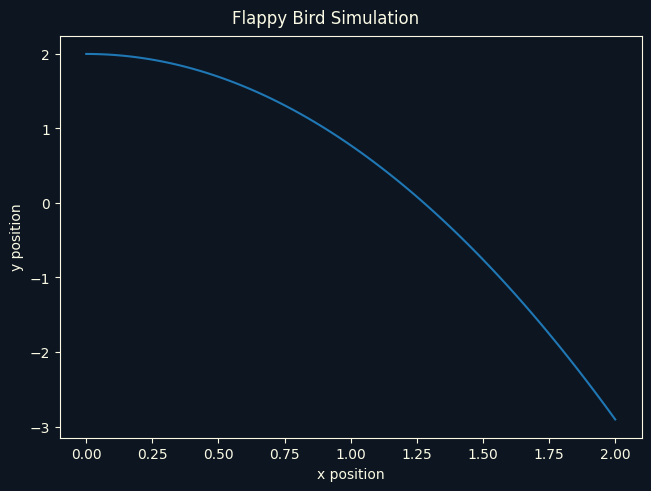

In [7]:
# util code!
from util.columnar import Columnar
from util.palette import blog_palette
from util.graph import Graph
from pathlib import Path
from dataclasses import dataclass, field


@dataclass
class SimData(Columnar):
    """ Transforming our data a little bit. Matplotlib plays nicer with iterables
        for each dimension, rather than one iterable where each element is an array
    """
    time: List[float]=field(default_factory=list)
    x_pos: List[float]=field(default_factory=list)
    y_pos: List[float]=field(default_factory=list)
    y_vel: List[float]=field(default_factory=list)
    pressed: List[int]=field(default_factory=list)

animation_csv = f""".flappy-height{{
        stroke:{blog_palette['foreground']};
        stroke-width:1.5;
        stroke-linecap:square;
        fill:{blog_palette['background']};
        stroke-dasharray:140%;
        stroke-dashoffset:140%;
        animation-name:flappy-height-anim;
        animation-duration:5s;
        animation-timing-function:linear;
        animation-fill-mode:forwards;
        animation-iteration-count: 1;
    }}
    @keyframes flappy-height-anim{{
        from{{
            stroke-dashoffset:140%;
        }}
        to{{
            stroke-dashoffset:0%;
        }}
    }}
    """

data = SimData.from_csv(
    Path("../tmp/flapping_birds_falling_birds.csv")
)
graph = Graph(
    background=blog_palette["background"],
    foreground=blog_palette["foreground"],
    title="Flappy Bird Simulation",
    figures=[(1,1,1)]
)
graph.set_axis_labels(0, "y position", "x position")
graph.plot(0, data.x_pos, data.y_pos, "flappy-height")
graph.add_style(
    "flappy-height",
    animation_csv
)
graph.save(Path("../content/images/flapping_birds_falling_birds.svg"))

![An animated graph of a very sad run of flappy bird]({static}/images/flapping_birds_falling_birds.svg)

Ok, well, that's not the most compelling graph I've seen in my entire life. Once again, we're going under 0, when that's our unofficial death floor. There's also no obstacles. Or even flapping.

Let's start with the last thing because it's in the damn name: let's make this flappy bird flap.

### Making Flappy Bird Flap

So, a "flap" in our simple version of Bird De Flap is when the "flap" button is held down-- the `pressed` element of our state vector. We use the `jump` function to move to the "flapping" state from the "falling" state (and from "falling" --> "flapping" as well). We know we _should_ be jumping when `jump_check` says so.

So, when do we want `jump_check` to be 1? Well, lets just say it should be one between certain times to start:

In [8]:
def jump_check(time:float, state:State) -> int:
    # ✨ New! ✨
    # we know our sim runs from time 0 to time 1, for right now. lets hardcode two jumps, one to set the "pressed"
    # element in our state vector, and one to unset it
    # bound the time so we only fire this once
    if time >= 0.5 and \
        time < 0.6 and \
            state[3] != 1: # the instant the button starts being pressed. Bound on both sides to only fire this once
        return 0
    elif time >= 0.6 and \
        state[3] != 0: # the instant the button stops being pressed.
        return 0
    else:
        return 1 # otherwise we're not jumping
    
jump_check.terminal = True # this function needs to stop our simulation, so its terminal now

In [9]:
flappy_bird_hybrid_system = HybridSystem(flow, flow_check, jump, jump_check)
hybrid_system_params = SystemParameters(0.0, 1.0, 5)
start_state = State(x_pos=0.0, y_pos=2.0, y_vel=0.0, pressed=0.0)
solution = solve_system(flappy_bird_hybrid_system, hybrid_system_params, start_state)
write_csv(solution, "../tmp/flapping_birds_single_flap.csv")

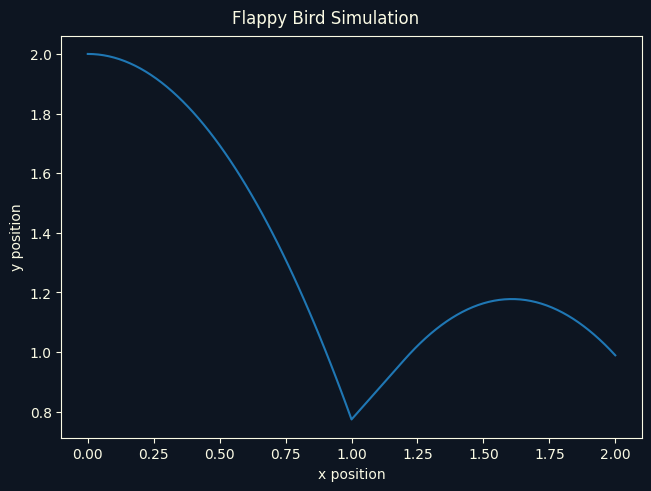

In [10]:
data = SimData.from_csv(
    Path("../tmp/flapping_birds_single_flap.csv"),
)
graph = Graph(
    background=blog_palette["background"],
    foreground=blog_palette["foreground"],
    title="Flappy Bird Simulation",
    figures=[(1,1,1)]
)
graph.set_axis_labels(0, "y position", "x position")
graph.plot(0, data.x_pos, data.y_pos, "flappy-height")
graph.add_style(
    "flappy-height",
    animation_csv
)
graph.save(Path("../content/images/flapping_birds_single_flap.svg"))

![An animated graph of a simulation where flappy makes a single jump]({static}/images/flapping_birds_single_flap.svg)

Alright, that's starting to look a little better. Obviously, hardcoding jump points isn't where we want to be in life, but hey! Flappy has a trajectory that looks kinda sane!

Now we need collision detection, so the simulation stops when Flappy hits the bottom or top of the screen.

### Making Flappy Bird Die
So, uh, how are we going to do this? We could have a new state, `dead` and jump to it when flappy collides with the floor or roof. But, that'll lead to a lot of wasted work: the sim will still spin forward until it gets to `end_time` with noting meaningful to do. We want to stop the sim early.

We know that `jump_check` stops the sim early (with ```jump_check.terminal = True```), so collision is like a jump where we just stop simulating rather than jump. Let's add a collision detection function and modify both `jump_check` and `solve_system`

In [11]:
 # ✨ New! ✨ Check to see if we're colliding with anything and need to die
def check_collision(state:State) -> bool:
    # the "height" of the level is gonna be a little arbitrary and hardcoded for now
    if state[1] <= 0.0 or state[1] >= 5.0:
        return True
    else:
        return False

# lets change jump_check to identify collisions  
def jump_check(time:float, state:State) -> int:
    # ✨ New! ✨
    if check_collision(state):
        return 0
 
    if time >= 0.5 and \
        time < 0.6 and \
            state[3] != 1:
        return 0
    elif time >= 0.6 and \
        state[3] != 0:
        return 0
    else:
        return 1
jump_check.terminal = True # we've got a new function, so we need to set this again

# and now we also need to change solve_system to distinguish between solution stops-- did we
# stop flowing because we hit something or because we started jumping?
def solve_system(system:HybridSystem, params:SystemParameters, start_state:State) -> List[Any]:
    solution:List[Any] = [] # gradual typing is neat!
    cur_time = params.start_time
    number_of_jumps = 0
    state = start_state

    while (cur_time < params.end_time and number_of_jumps < params.max_jumps):
        if(system.flow_check(cur_time, state) == 0):
            ode_sol = integrate.solve_ivp(
                system.flow,
                (cur_time, params.end_time),
                state,
                events=[system.jump_check],
                max_step=0.01,
                atol=1e-6,
                rtol=1e-6
            )
            if ode_sol.status == -1:
                print(f"Solver failed with message: {ode_sol.message}")
                return solution
            for time, state in zip(ode_sol.t, ode_sol.y.T):
                solution.append((time, state))

            cur_time, state = solution[-1]
        
        # ✨ New! ✨
        if check_collision(state):
            return solution
        
        if (system.jump_check(cur_time, state) == 0):
            state = jump(cur_time, state)
            number_of_jumps += 1
    
    return solution

In [12]:
flappy_bird_hybrid_system = HybridSystem(flow, flow_check, jump, jump_check)
# ✨ New! ✨ setting a much longer end time, we should stop before we get there!
hybrid_system_params = SystemParameters(0.0, 5.0, 5)
start_state = State(x_pos=0.0, y_pos=2.0, y_vel=0.0, pressed=0.0)
solution = solve_system(flappy_bird_hybrid_system, hybrid_system_params, start_state)
write_csv(solution, "../tmp/flapping_birds_single_flap_long.csv")

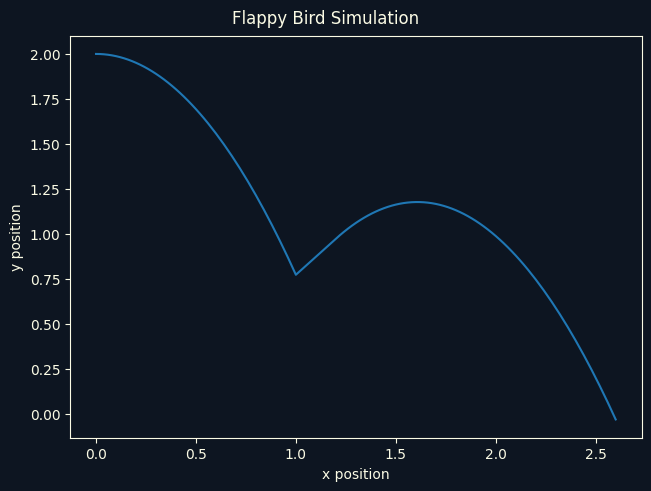

In [13]:
data = SimData.from_csv(
    Path("../tmp/flapping_birds_single_flap_long.csv")
)
graph = Graph(
    background=blog_palette["background"],
    foreground=blog_palette["foreground"],
    title="Flappy Bird Simulation",
    figures=[(1,1,1)]
)
graph.set_axis_labels(0, "y position", "x position")
graph.plot(0, data.x_pos, data.y_pos, "flappy-height")
graph.add_style(
    "flappy-height",
    animation_csv
)
graph.save("../content/images/flapping_birds_single_flap_long.svg")

### Stuff To Dodge

Having an upper and lower bound is all well and good, but really Flappy Bird is hard because there is something to, ya know, dodge. Flap _around_. We need to add some obstacles. Classically, this is pipes-- but we don't really need things like "sprites", "graphics" or "art" in simulation land. We just care that there are some rectangular death zones spaced somewhat regularly apart.

I could start by hardcoding the pipe locations just like the level boundaries locations, but uuuuh. Look, I didn't love hardcoding in the boundaries in the last part and I want to eventually graph where the death zones are. It's time for a data structure.

In [15]:
from pprint import pprint
@dataclass
class BoundingBox():
    """ Its a rectangle! Represented by the top left point, a width and a height
    """
    top_left: Tuple[float, float]
    width: float
    height: float

@dataclass
class FlappyLevel():
    """ It's a flappy bird level! We get a ceiling (going to high means death),
        a floor (going to low means death), and a list of obstacles (touching means death)
    """
    floor:float
    ceiling:float
    obstacles: List[BoundingBox]

sample_level = FlappyLevel(
    floor=0.0,
    ceiling=5.0,
    obstacles=[
        BoundingBox(
            top_left=(1.0, 5.0),
            width=0.5,
            height=0.5
        ),
        BoundingBox(
            top_left=(1.5, 0.75),
            width=0.5,
            height=0.75
        )
    ]
)
pprint(sample_level)

FlappyLevel(floor=0.0,
            ceiling=5.0,
            obstacles=[BoundingBox(top_left=(1.0, 5.0), width=0.5, height=0.5),
                       BoundingBox(top_left=(1.5, 0.75),
                                   width=0.5,
                                   height=0.75)])


Ok, not the prettiest printing of all time there, but it'll do. Now, we need to update our `jump_check` function to actually use it. So, let's just add an argument-- oh.

well, uh.

hm.

Remember that `jump_check` must be in a very particular form because it's going to get called by `scipy` owned code as a part of `solve_ivp`. We can't just add an argument, the solver doesn't know anything about the level. There are a few ways to go forward here:
1. we control how `jump_check` executes and what it's scope is. We can save the level as a variable that's in scope while `jump_check` is doing its thing
2. that, but more formal: classes and objects

Which means, ugh, variable lifetime and all the other annoying things you need to start thinking about when you move from beyond easy "function only operates on its arguments" land. The Haskell people were right, side effects suck. Eventually, we're going to want to run many simulations on one level [^2], so wrapping up everything as a "simulation" class makes sense to me. The stuff that stays the same from run to run becomes class attributes, and we can pass the stuff that differs into the `solve_system` instance method.

Because [bound methods of instances](https://docs.python.org/3.11/reference/datamodel.html#instance-methods) work like a regular old callable from the outside, we can have the object "ride along" with invocation, with our solver being non-the-wiser [^3]

Does that make sense? I hope so. 3,2,1, let's jam.

[^2]: spoilers
[^3]: this behavior is not free-- I do pay a small penalty for passing in the instance as the first argument, but lord, do I have bigger problems elsewhere.

In [16]:
from util.print import blog_print

class FlappyHybridSim:
    """ This simulation class combines all the simulation constants, like a level, simulation parameters and ye four
        functions.
    """
    level: FlappyLevel
    max_step:float
    atol:float
    rtol:float
    def __init__(self, level:FlappyLevel):
        self.level = level
        # probably should be parameters, but spoilers: these numbers are basically never changing
        # this pressed velocity term is also equal to how fast flappy goes forward on their own
        self.pressed_velocity=2.0
        self.falling_acceleration=-9.81
        self.max_step=0.01
        self.atol=1e-6
        self.rtol=1e-6

    # ✨ New! ✨ new logic to make sure we're not hitting a box, and integration with our level structure
    def solve_system(self, params:SystemParameters, start_state:State) -> List[Any]:
        solution:List[Any] = [] # gradual typing is neat!
        cur_time = params.start_time
        number_of_jumps = 0
        state = start_state

        if(self._flow_check(cur_time, state) == 0):
            ode_sol = integrate.solve_ivp(
                self._flow,
                (cur_time, params.end_time),
                state,
                events=[self._jump_check],
                max_step=0.01,
                atol=1e-6,
                rtol=1e-6
            )
            if ode_sol.status == -1:
                print(f"Solver failed with message: {ode_sol.message}")
                return solution
            for time, state in zip(ode_sol.t, ode_sol.y.T):
                solution.append((time, state))

            cur_time, state = solution[-1]
        
  
            if self._check_collision(state):
                return solution
        
            if (self._jump_check(cur_time, state) == 0):
                state = self._jump(cur_time, state)
                number_of_jumps += 1
    
        return solution
    
    # ✨ New! ✨ We're integrating the level into this function!
    def _check_collision(self, state:State) -> bool:
        if state[1] <= self.level.floor or state[1] >= self.level.ceiling:
            return True
        
        # we need to actually see if we're inside a death box or not
        # in a real game, we'd want to do a location based query (tell me what's nearby so I only check against nearby
        # things) but our level is so simple right now, we can just test against all the geometry
        for box in self.level.obstacles:
            # I'm like 99% sure there's a way to rephrase this hellish if statement
            # this'll get called within our solver, so state has lost it's nice property names :c
            if state[0] >= box.top_left[0] and \
                state[0] <= box.top_left[0] + box.width and \
                state[1] >= box.top_left[0] and \
                state[1] <= box.top_left[1] + box.height:
                return True

        return False

    # you've seen the rest of these functions before, they're just part of a class now
    # I'm using the _ to sort of imply that these should never be called outside the `solve_system`
    # function. No touchie.
    def _flow(self, time:float, state:State) -> Tuple[float, float, float, int]:
        if state[3] == 0:
            return StateDerivative(
                delta_x_pos=self.pressed_velocity,
                delta_y_pos=state[2],
                delta_y_vel=self.falling_acceleration,
                delta_pressed=0
            )
        elif state[3] == 1: #pressed
            return StateDerivative(
                delta_x_pos=self.pressed_velocity, 
                delta_y_pos=self.pressed_velocity,
                delta_y_vel=0,
                delta_pressed=0 
            )
        else:
            raise RuntimeError(f"Invalid state! {state}, pressed != 0 or 1")

    def _flow_check(self, time:float, state:State) -> int:
        return 0

    def _jump(self, time:float, state:State) -> Tuple[float, float, float, int]:
        new_pressed = abs(state[3] - 1)
        if new_pressed == 1:
            return State(
                x_pos=state[0],
                y_pos=state[1],
                y_vel=self.pressed_velocity,
                pressed=new_pressed
            )
        else:
            return State(
                x_pos=state[0],
                y_pos=state[1],
                y_vel=state[2],
                pressed=new_pressed
            )
    
    def _jump_check(self, time:float, state:State) -> int:
        if self._check_collision(state):
            return 0
 
        if time >= 0.5 and \
            time < 0.6 and \
                state[3] != 1:
            return 0
        elif time >= 0.6 and \
            state[3] != 0:
            return 0
        else:
            return 1
    _jump_check.terminal = True

hybrid_system_params = SystemParameters(0.0, 5.0, 5)
start_state = State(x_pos=0.0, y_pos=2.0, y_vel=0.0, pressed=0.0)
sim = FlappyHybridSim(sample_level)
solution = sim.solve_system(hybrid_system_params, start_state)
blog_print(solution, lambda line: f"State at {line[0]:0.04f}: {[f'{val:0.04f}' for val in line[1]]}")

State at 0.0000: ['0.0000', '2.0000', '0.0000', '0.0000']
State at 0.0100: ['0.0200', '1.9995', '-0.0981', '0.0000']
State at 0.0200: ['0.0400', '1.9980', '-0.1962', '0.0000']
...
State at 0.4800: ['0.9600', '0.8699', '-4.7088', '0.0000']
State at 0.4900: ['0.9800', '0.8223', '-4.8069', '0.0000']
State at 0.5000: ['1.0000', '0.7737', '-4.9050', '0.0000']


Ugh, as a graph, please?

# TODO: other obstacles, coloring graphs by jump